## RIVERS-PILOT EXPERIMENT OVERVIEW

    The rivers-pilot project runs the realistic SSC, v201812 (good bloom timing), from the following run directory:
        SS-run-sets/SalishSea/nemo3.6/tereza/RIVERS/RIVERS_pilot
        
    Restarts are from /results/SalishSea/nowcast-green.201812/31dec16
    
    There are two run scenarios, base and SHIFT, which use identical namelist.times and have the following diff patterns per yamls (base v SHIFT):
                < run_id: RP_base_1
            ---
            > run_id: RP_base_1_SHIFT
            20c20
            <     link to: $PROJECT/tjarnik/MEOPAR/RIVERS_files/daily_R201702/
            ---
            >     link to: $PROJECT/tjarnik/MEOPAR/RIVERS_files/daily_45Dearly/
            54c54
            <   - ./namelist.atmos_rivers
            ---
            >   - ./namelist.atmos_riversSHIFT
            
    The RIVERS_files are made in: 
        notebooks/RIVER_PAPER/RIVERS_pilot/make_daily_files and make_daily_files_shifted_hydrograph
    These use daily interpolated values from monthly averages, for all rivers except the fraser, where realistic 2017 values are used. 
    
    Then we shift the 'glacial' watersheds, as well as the Fraser river, forward 45 days to examine effects. 
        (not the rest of the fraser watershed; this is because Tereza forgot. 
        Not really a problem though, for a pilot run)
    The glacial watersheds are: wat_to_rot = ['skagit', 'howe', 'bute', 'toba']
    
    Results are stored in: /data/tjarniko/results/RIV_PIL
    
## NOTEBOOK OVERVIEW

    1. Here we first visualize the rivers in the SalishSeaCast model by watershed. 
    
    2. We then look at hydrograph patterns by watershed, identifying 
    the largest 5 rivers in each watershed by runoff.
    
    3. We then introduce the river_acid_observatory tool, which shows the hydgrograph of each river of interest 
    as well as key inorg. C cycle variables in the vicinity of its mouth: 
    S, nitrate, diatoms, TA-DIC, DIC, nDIC, and Omega.
    We consider two radii of importance: 3 grid cells from river mouth (~1.5 km) and 10 grid cells (5 km)
    The exception is the Fraser, where we have to consider a point not at the river mouth. 
    
    4. We apply the river_acid_observatory tool to the largest river in each watershed, 
    for both the BASE and the SHIFT runs. 
    
    5. We also build a river_flux_observatory tool, which shows the hydrograph of each river of interest 
    as well as key carbon air-sea flux variables in the vicinity of its mouth:  
    pCO2, delta-pCO2, wind strength, and flux. We apply this to the largest rivers in the watershed as well. 
    

In [15]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [16]:
import sys
import numpy as np
import netCDF4 as nc
import cmocean as cm
import matplotlib.pyplot as plt
import pickle
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)
sys.path.append('/data/tjarniko/mocsy')
import mocsy
import arrow
import gsw
import glob
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')

import river_201702 as rv

### Nearshore plots

##### What is the influence of a changing river cycle on near-shore carbonate chemistry and ocean acidification metrics?


In [46]:
def wshed_plot(surfdat_1,tit1,t_cmap,xsize,ysize,v_min1,v_max1,cl1,bigtit):
    "TESTED"

    fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize), sharey=True)
    cmap = t_cmap
            

    tplt = np.ma.masked_values(surfdat_1,0)
    ax.set_title(tit1,fontsize = 20 )
    v_min = v_min1
    v_max = v_max1
    clabel = cl1

    viz_tools.set_aspect(ax)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max) 
    ax.set_xlabel('x Index', fontsize = 20 )
    ax.set_ylabel('y Index', fontsize = 20 )
    

    watersheds = rv.prop_dict.keys()
    #watershed counter
    wc = 0
    tr = 0
    wsl = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
    for watshed in watersheds:
        #print(watshed)
        rivs = rv.prop_dict[watshed].keys()
        #river counter for index
        rc = 0
        for riv in rivs:

            ti = rv.prop_dict[watshed][riv]['i']
            tj = rv.prop_dict[watshed][riv]['j']
            
            if ((wsl[wc] == 'Homathko') & (rc ==0)):
#             if rc==0: 
                 pts = ax.scatter(tj,ti,s=30,c=cols[wc],label = wsl[wc],marker='o')
                
            else:
                pts = ax.scatter(tj,ti,s=30,c=cols[wc],marker='o')
            
            if riv == 'Homathko':
                ax.text(tj+20,ti-20,riv, weight = 'bold', fontsize = 10)
                pts = ax.scatter(tj-3,ti-10,s=200,c=cols[wc],label = wsl[wc],marker='*')
            
#             samprivs = ['SanJuan', 'Skagit1', 'Puyallup', 'Nanaimo1', 'Homathko', 'Toba', 'Squamish', 'Englishman'] #samprivs = []
#             if riv in samprivs:
#                 ax.text(tj+5,ti,riv, weight = 'bold', fontsize = 14)

            rc = rc+1
            tr = tr+1
        wc = wc+1
    
    ax.scatter(300,425,s=200,c='k',label = 'Fraser-obs?',marker='*')
   

    plt.xlim([0,398])
    plt.ylim([0,898])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    cmap.set_bad('lightslategray')
    plt.legend(bbox_to_anchor=(1.29, 0.95))
    plt.suptitle(bigtit,fontsize=20)

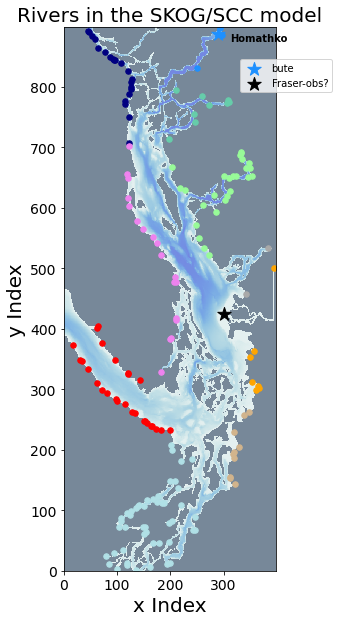

In [47]:
fact = 0.4
bath = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
bath1 = bath.variables['Bathymetry']
wshed_plot(bath1,'Rivers in the SKOG/SCC model', \
               cm.cm.dense,15*fact,25*fact,0,1000,'bathymetry','')

In [82]:
cols = ['darkgray','red','chocolate','tan','orange',\
    'navy','palegreen','mediumaquamarine','dodgerblue','violet']
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

def wshed_plot(surfdat_1,tit1,t_cmap,xsize,ysize,v_min1,v_max1,cl1,bigtit):
    "TESTED"

    fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize), sharey=True)
    cmap = t_cmap
            

    tplt = np.ma.masked_values(surfdat_1,0)
    ax.set_title(tit1,fontsize = 20 )
    v_min = v_min1
    v_max = v_max1
    clabel = cl1

    viz_tools.set_aspect(ax)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max) 
#     ax.set_xlabel('x Index', fontsize = 20 )
#     ax.set_ylabel('y Index', fontsize = 20 )
    

    watersheds = rv.prop_dict.keys()
    #watershed counter
    wc = 0
    tr = 0
    wsl = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
    wsl = ['Howe', 'Juan de Fuca', 'Puget', 'Skagit', 'Fraser (greater area)', 'North Vancouver Island', 
              'Jervis', 'Toba', 'Bute', 'South Vancouver Island']
    for watshed in watersheds:
        #print(watshed)
        rivs = rv.prop_dict[watshed].keys()
        #river counter for index
        rc = 0
        for riv in rivs:

            ti = rv.prop_dict[watshed][riv]['i']
            tj = rv.prop_dict[watshed][riv]['j']
            if (tj == 298):
                print(tj)
            if ((rc==0) & (tj!=298)): 
                pts = ax.scatter(tj,ti,s=30,c=cols[wc],marker='o')
                
            if ((rc!=0) & (tj!=298)):
                pts = ax.scatter(tj,ti,s=30,c=cols[wc],marker='o')
            if riv == 'Homathko':
                #ax.text(tj+20,ti-20,riv, weight = 'bold', fontsize = 10)
                pts = ax.scatter(tj-3,ti-10,s=200,c=cols[wc],label = wsl[wc],marker='*')
                ax.text(tj-250,ti-30,'Homathko nearshore station', weight = 'bold')
            if riv == 'Squamish':
                #ax.text(tj+-50,ti-25,riv, weight = 'bold', fontsize = 10)
                pts = ax.scatter(tj-5,ti-5,s=200,c=cols[wc],label = wsl[wc],marker='*')
                ax.text(tj-250,ti-30,'Squamish nearshore station', weight = 'bold')
            #ax.text(tj+5,ti,riv, weight = 'bold', fontsize = 10)
            
#             samprivs = ['SanJuan', 'Skagit1', 'Puyallup', 'Nanaimo1', 'Homathko', 'Toba', 'Squamish', 'Englishman'] #samprivs = []
#             if riv in samprivs:
#                 ax.text(tj+5,ti,riv, weight = 'bold', fontsize = 14)

            rc = rc+1
            tr = tr+1
        wc = wc+1
    
    #ax.scatter(380,415,s=150,c='orange',label = 'Fraser',marker='*')
    ax.scatter(300,425,s=200,c='orange',label = 'Fraser nearshore station',marker='*')
    ax.text(180,400,'Fraser nearshore station', weight = 'bold')
    plt.xlim([0,390])
    plt.ylim([0,898])
    
    plt.xticks([])
    plt.yticks([])
    cmap.set_bad('white')
    #plt.legend(bbox_to_anchor=(1.05, 1), ncol = 3)
    plt.suptitle(bigtit,fontsize=9)

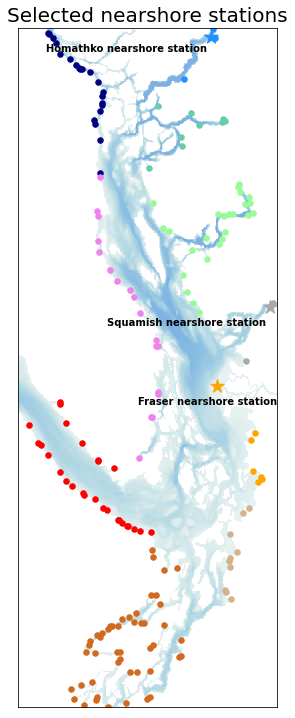

In [84]:
fact = 0.5
bath = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
bath1 = bath.variables['Bathymetry']
wshed_plot(bath1,'Selected nearshore stations', \
               cm.cm.dense,15*fact,25*fact,0,1500,'bathymetry','')

In [77]:

watersheds = rv.prop_dict.keys()
riv_i = []
riv_j = []
riv_shed = []
riv_name = []
i = 0
for watshed in watersheds:
    #print('~~')
    rivs = rv.prop_dict[watshed].keys()
    for riv in rivs:
        #print('Riv: '+riv+', watershed: '+watshed)
        #swap is, js here
        ti = rv.prop_dict[watshed][riv]['j']
        tj = rv.prop_dict[watshed][riv]['i']
        riv_i.append(ti)
        riv_j.append(tj)
        riv_shed.append(watshed)
        riv_name.append(riv)
        i = i+1


gauge_riv = ['Squamish','SanJuan','Elwha','DungenessMatriotti','Hoko','LittleBigQuilcene',\
            'Duckabush','Skokomish','DeerJohnsGoldboroughMill','Deschutes','Chambers',\
            'Chambers','NisquallyMcAllister','Puyallup','CedarSammamish','Skagit1',\
            'Samish','Stillaguamish1','SnohomishAllenQuilceda','Tulalip','Mission',\
            'Nooksack','Fraser','Oyster','Qunisam','SalmonSayward','Theodosia',
             'Homathko','Cowichan1','Chemanius1','Nanaimo1','Englishman',
             'LittleQualicum','Puntledge']

cols = ['darkgray','red','powderblue','tan','orange',\
    'navy','palegreen','mediumaquamarine','dodgerblue','violet']
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

# Rivers in the SKOG model

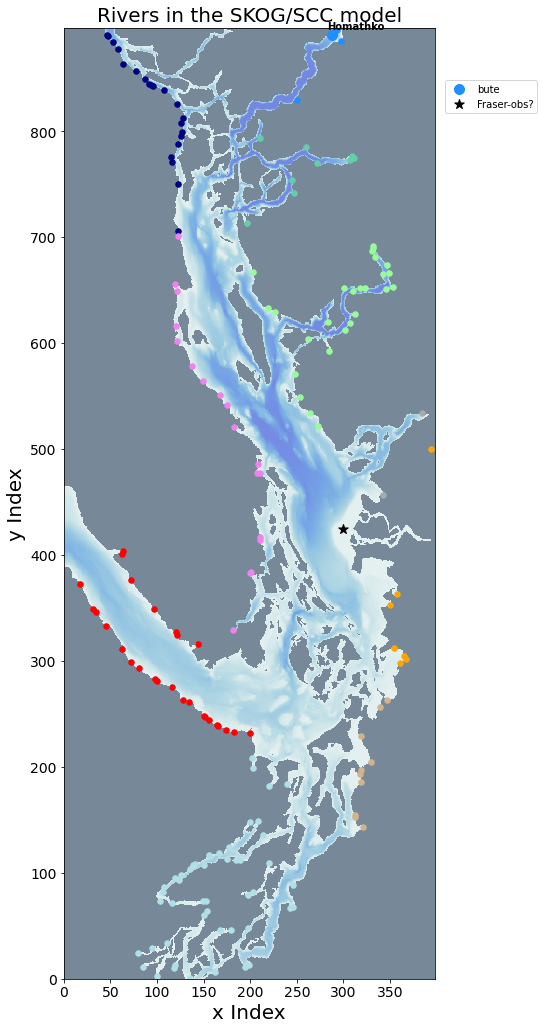

### calculate runoffs

In [20]:
import pickle
#pickle.dump(hydro_old_Fraser, open("hydroFraser_2017real.pkl", 'wb'))
hydroFraser_2017real = pickle.load(open('./hydroFraser_2017real.pkl', 'rb'))  

climatology_file = \
nc.Dataset('/data/tjarniko/MEOPAR/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')

import copy
clim_dict = copy.deepcopy(rv.prop_dict)
grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
wat_to_rot = ['skagit', 'howe', 'bute', 'toba']
for w in watersheds:
    interp_clim = climatology_file[w][:]

    #print(w)
    #print(interp_clim)
    rivers = (rv.prop_dict[w].keys())
    for r in rivers:
        #print(r)
        prop_wshed = rv.prop_dict[w][r]['prop']
        clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
        river_i = rv.prop_dict[w][r]['j']
        river_j = rv.prop_dict[w][r]['i']
        river_dj = rv.prop_dict[w][r]['di']
        river_di = rv.prop_dict[w][r]['dj']
        area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]
        clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
        clim_dict[w][r]['interp_clim_modunits_SHIFT'] = prop_wshed * interp_clim / area * 1000
        if w in wat_to_rot:
            clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll((prop_wshed * interp_clim / area * 1000),-45) 
        
        
        
        if ((w == 'fraser') & (r == 'Fraser')):
            clim_dict[w][r]['interp_clim_modunits'] = hydroFraser_2017real
            clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll(hydroFraser_2017real,-45)
            
            
            

## watersheds of the model, with 5 largest rivers labeled

#### note that water is in model units: kg of water/m2 /s

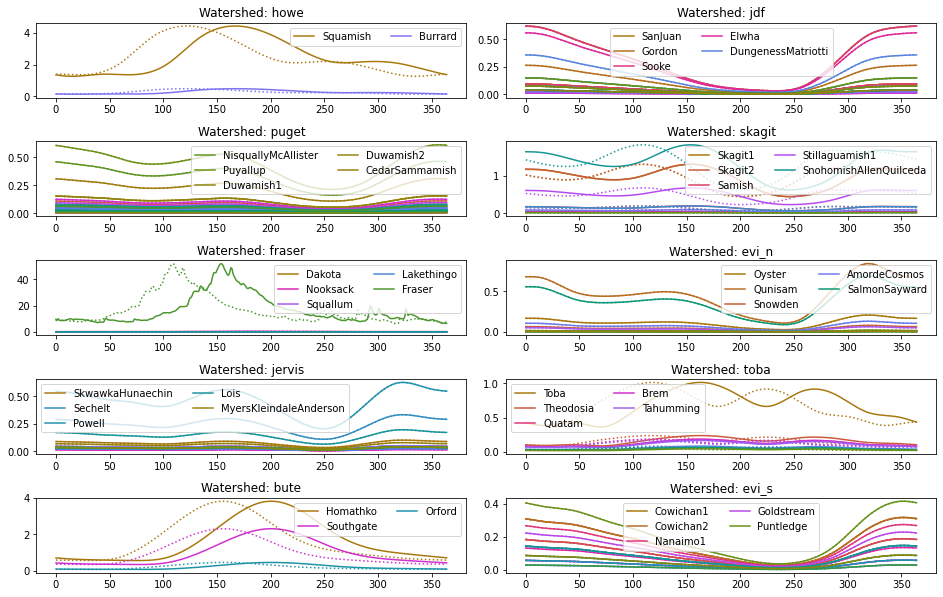

In [21]:
cmap = cm.cm.phase  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]


watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#911eb4',\
        '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',\
         '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000',\
        '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000',
       'black','mediumseagreen','olivedrab','yellow','saddlebrown']


fact = 0.6

fig = plt.figure(figsize=(22*fact,14*fact))
for i in range(1,11):
    
    ax = fig.add_subplot(5,2,i)
    w = watersheds[i-1]
    rivs = (clim_dict[w].keys())
        
        #sort rivers highest to smallest and get top 5 rivers, only label those
    rivlist = list(rivs)
    runlist = []

    for riv in rivs:
        maxrun = np.max(clim_dict[w][riv]['interp_clim_modunits'])
        runlist.append(maxrun)

    runar = np.array(runlist)
    rivar = np.array(rivlist)
    inds = runar.argsort()[::-1]
    sortriv = rivar[inds]
    biggest_riv = (sortriv[0:5])
    #print(biggest_riv)
    count = 0 
    numriv = np.size(rivlist)
    for riv in rivs:
        
        if riv in (biggest_riv):
            #yrprop = int((yr-1963) /(2018-1963) * 256)
            #print(int(count/numriv * 256))
            ax.plot(clim_dict[w][riv]['interp_clim_modunits'], label = riv, color = cmaplist[int(count/numriv * 256)], linewidth = 1.5)
        else:
            ax.plot(clim_dict[w][riv]['interp_clim_modunits'], color = cmaplist[int(count/numriv * 256)], linewidth = 1.5)
        ax.plot(clim_dict[w][riv]['interp_clim_modunits_SHIFT'], linestyle = ':', color = cmaplist[int(count/numriv * 256)], linewidth = 1.5)
        count = count+1
    ax.legend(ncol = 2, loc = 'best')
    ax.set_title('Watershed: '+ w, fontsize = 12)
   

plt.tight_layout()

### watersheds of the model, showing only the top 5 rivers in each watershed

howe
['Squamish' 'Burrard']
jdf
['SanJuan' 'Sooke' 'Elwha' 'DungenessMatriotti' 'Gordon']
puget
['Puyallup' 'NisquallyMcAllister' 'CedarSammamish' 'Duwamish2' 'Duwamish1']
skagit
['SnohomishAllenQuilceda' 'Skagit2' 'Skagit1' 'Stillaguamish1' 'Samish']
fraser
['Fraser' 'Nooksack' 'Dakota' 'Lakethingo' 'Squallum']
evi_n
['Qunisam' 'SalmonSayward' 'Oyster' 'AmordeCosmos' 'Snowden']
jervis
['Powell' 'Sechelt' 'Lois' 'SkwawkaHunaechin' 'MyersKleindaleAnderson']
toba
['Toba' 'Theodosia' 'Brem' 'Quatam' 'Tahumming']
bute
['Homathko' 'Southgate' 'Orford']
evi_s
['Puntledge' 'Cowichan1' 'Cowichan2' 'Nanaimo1' 'Goldstream']


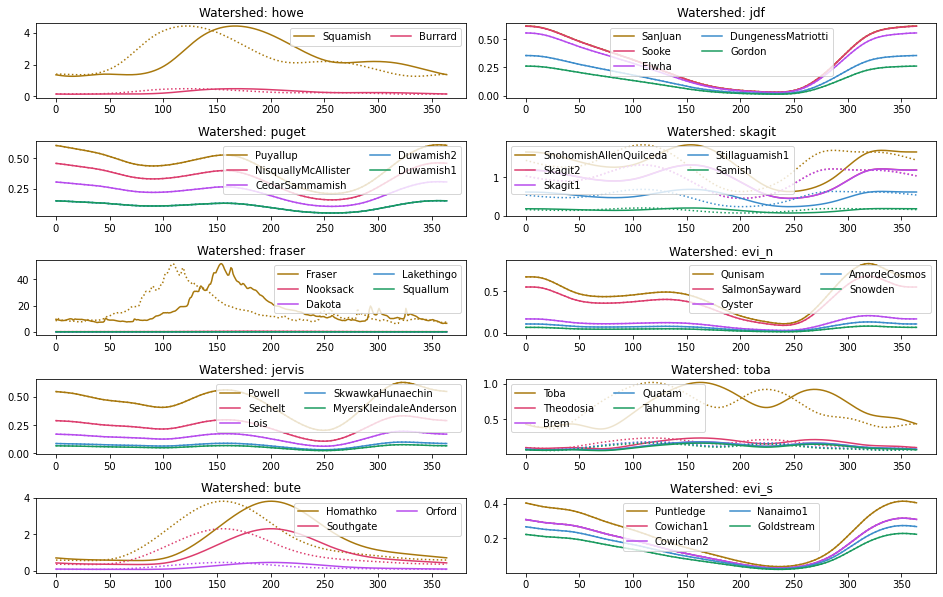

In [22]:
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

fact = 0.6

fig = plt.figure(figsize=(22*fact,14*fact))
for i in range(1,11):
    
    ax = fig.add_subplot(5,2,i)
    w = watersheds[i-1]
    rivs = (clim_dict[w].keys())
        
        #sort rivers highest to smallest and get top 5 rivers, only label those
    rivlist = list(rivs)
    runlist = []

    for riv in rivs:
        maxrun = np.max(clim_dict[w][riv]['interp_clim_modunits'])
        runlist.append(maxrun)

    runar = np.array(runlist)
    rivar = np.array(rivlist)
    inds = runar.argsort()[::-1]
    sortriv = rivar[inds]
    biggest_riv = (sortriv[0:5])
    print(w)
    print(biggest_riv)
    count = 0
    for riv in biggest_riv:
       
        #if riv in (biggest_riv):
        #print(count)
        #print(int(count/5 * 256))
        ax.plot(clim_dict[w][riv]['interp_clim_modunits'], label = riv, color = cmaplist[int(count/5 * 256)])
        ax.plot(clim_dict[w][riv]['interp_clim_modunits_SHIFT'], linestyle = ':', color = cmaplist[int(count/5 * 256)])
        count = count+1

    ax.legend(ncol = 2, loc = 'best')
    ax.set_title('Watershed: '+ w, fontsize = 12)

plt.tight_layout()

##### extraction functions for rivers (extract_ts_BASE and extract_ts_SHIFT) in _make_DICTS nb


In [23]:
def make_diag_plot_dictv(whsed, rivnam, rivstr, rivstr_SHIFT, sd, ed):
    
    riv_runoff = clim_dict[whsed][rivnam]['interp_clim']
    riv_runoff_SHIFT = riv_runoff
    wat_to_rot = ['skagit', 'howe', 'bute', 'toba']
    if whsed in wat_to_rot:
        riv_runoff_SHIFT = np.roll(riv_runoff,-45)
        
    if rivnam == 'Fraser':
        riv_runoff = hydroFraser_2017real
        riv_runoff_SHIFT = np.roll(hydroFraser_2017real,-45)

    riv_pkl = pickle.load(open(rivstr, 'rb'))  
    riv_pkl_SHIFT = pickle.load(open(rivstr_SHIFT, 'rb'))  
    #print(riv_runoff)
    
    radloc = 3
    radbroad = 10

    sal_loc = riv_pkl['sal_rad3']
    sal_broad = riv_pkl['sal_rad10']
    sal_loc_SHIFT= riv_pkl_SHIFT['sal_rad3']
    sal_broad_SHIFT= riv_pkl_SHIFT['sal_rad10'] 
    
    fs = 14
    fact = 0.65
    fig = plt.figure(figsize=(22*fact,38.5*fact))
    for i in range(1,11):
        ax = fig.add_subplot(10,2,i)

        
        #river cycle 
        if i == 1:
            ax.plot(np.arange(1,366,1),riv_runoff,'k-', label = 'BASE')
            ax.plot(np.arange(1,366,1),riv_runoff_SHIFT,'r-', label = 'SHIFT')
            ax.set_xlim([0,400])
            ax.set_title('Runoff by DOY, river: '+rivnam +'\n (time of interest highlighted)', fontsize = fs)
            ax.set_ylabel('m$^3$s$^{-1}$')
            ax.set_xlabel('day of year')
            ax.legend(loc = 'best')
            
            ## plotting errorbars
            plt.errorbar(405, np.mean(riv_runoff_SHIFT), np.std(riv_runoff_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            plt.errorbar(385, np.mean(riv_runoff), np.std(riv_runoff), \
                         linestyle='-', marker='.', color = 'k')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])
        
#         #salinity
        if i == 3:
            ax.plot(np.arange(sd,ed+1,1),sal_loc,'k-', label = 'rad. = '+str(radloc) +' cells \n from rivmouth')
            ax.plot(np.arange(sd,ed+1,1),sal_broad,'k:', label = 'rad. = '+str(radbroad) +' cells')
            ax.plot(np.arange(sd,ed+1,1),sal_loc_SHIFT,'r-', )
            ax.plot(np.arange(sd,ed+1,1),sal_broad_SHIFT,'r:' )

            ax.set_xlim([0,400])
            plt.legend(loc = 3)
            ax.set_ylabel('salinity g/kg')
            ax.set_xlabel('day of year')
            ax.set_title('Salinity', fontsize = fs)
            ####### plotting errorbars
            plt.errorbar(405, np.mean(sal_loc_SHIFT), np.std(sal_loc_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(sal_broad_SHIFT), np.std(sal_loc_SHIFT), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(sal_loc), np.std(sal_loc), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(sal_broad), np.std(sal_loc), \
                         linestyle=':', marker='.', color = 'k')   
            a2[-1][0].set_linestyle(':')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])

        
        if i == 5:
            diatoms_loc = riv_pkl['diatoms_rad3']
            diatoms_broad = riv_pkl['diatoms_rad10']
            ax.plot(np.arange(sd,ed+1,1),diatoms_loc,'k-')
            ax.plot(np.arange(sd,ed+1,1),diatoms_broad,'k:')
            
            diatoms_loc_SHIFT= riv_pkl_SHIFT['diatoms_rad3']
            diatoms_broad_SHIFT= riv_pkl_SHIFT['diatoms_rad10']
            ax.plot(np.arange(sd,ed+1,1),diatoms_loc_SHIFT,'r-', )
            ax.plot(np.arange(sd,ed+1,1),diatoms_broad_SHIFT,'r:' )
            
#             ax.plot(np.arange(sd,ed+1,1),diat_loc,'k-', label = 'radius = '+str(radloc) +' cells \n from rivermouth')
#             ax.plot(np.arange(sd,ed+1,1),diat_broad,'k:', label = 'radius = '+str(radbroad) +' cells \n from rivermouth')
            ax.set_xlim([0,400])
            ax.set_ylabel('diatoms  mmol N m$^{-3}$')
            ax.set_xlabel('day of year')
            ax.set_title('Primary Productivity (diatoms)', fontsize = fs)
            
            plt.errorbar(405, np.mean(diatoms_loc_SHIFT), np.std(diatoms_loc_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(diatoms_broad_SHIFT), np.std(diatoms_loc_SHIFT), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(diatoms_loc), np.std(diatoms_loc), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(diatoms_broad), np.std(diatoms_loc), \
                         linestyle=':', marker='.', color = 'k')   
            a2[-1][0].set_linestyle(':')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])
            
        if i == 7:
            nitrate_loc = riv_pkl['nitrate_rad3']
            nitrate_broad = riv_pkl['nitrate_rad10']
            ax.plot(np.arange(sd,ed+1,1),nitrate_loc,'k-')
            ax.plot(np.arange(sd,ed+1,1),nitrate_broad,'k:')
            
            nitrate_loc_SHIFT= riv_pkl_SHIFT['nitrate_rad3']
            nitrate_broad_SHIFT= riv_pkl_SHIFT['nitrate_rad10']
            ax.plot(np.arange(sd,ed+1,1),nitrate_loc_SHIFT,'r-', )
            ax.plot(np.arange(sd,ed+1,1),nitrate_broad_SHIFT,'r:' )
            
#             ax.plot(np.arange(sd,ed+1,1),diat_loc,'k-', label = 'radius = '+str(radloc) +' cells \n from rivermouth')
#             ax.plot(np.arange(sd,ed+1,1),diat_broad,'k:', label = 'radius = '+str(radbroad) +' cells \n from rivermouth')
            ax.set_xlim([0,400])
            ax.set_ylabel('nitrate  mmol N m$^{-3}$')
            ax.set_xlabel('day of year')
            ax.set_title('Nutrients (nitrate)', fontsize = fs)
            plt.errorbar(405, np.mean(nitrate_loc_SHIFT), np.std(nitrate_loc_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(nitrate_broad_SHIFT), np.std(nitrate_loc_SHIFT), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(nitrate_loc), np.std(nitrate_loc), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(nitrate_broad), np.std(nitrate_loc), \
                         linestyle=':', marker='.', color = 'k')   
            a2[-1][0].set_linestyle(':')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])
#         plt.tight_layout()
        
        if i == 2:
            DIC_loc = riv_pkl['DIC_rad3']
            DIC_broad = riv_pkl['DIC_rad10']
            ax.plot(np.arange(sd,ed+1,1),DIC_loc,'k-')
            ax.plot(np.arange(sd,ed+1,1),DIC_broad,'k:')
            
            DIC_loc_SHIFT= riv_pkl_SHIFT['DIC_rad3']
            DIC_broad_SHIFT= riv_pkl_SHIFT['DIC_rad10']
            ax.plot(np.arange(sd,ed+1,1),DIC_loc_SHIFT,'r-', )
            ax.plot(np.arange(sd,ed+1,1),DIC_broad_SHIFT,'r:' )            
            ax.set_xlim([0,400])
            ax.set_ylabel('DIC  mmol m$^{-3}$')
            ax.set_xlabel('day of year')
            ax.set_title('DIC', fontsize = fs)
            plt.errorbar(405, np.mean(DIC_loc_SHIFT), np.std(DIC_loc_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(DIC_broad_SHIFT), np.std(DIC_loc_SHIFT), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(DIC_loc), np.std(DIC_loc), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(DIC_broad), np.std(DIC_loc), \
                         linestyle=':', marker='.', color = 'k')   
            a2[-1][0].set_linestyle(':')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])
            #         plt.tight_layout()
        
#         ##nX = Xobs × 35/Sobs,
        if i == 4:
            if rivnam != 'Fraser':
                ax.plot(np.arange(sd,ed+1,1),(DIC_loc - 660) *30/sal_loc + 660 ,'k-' )
                ax.plot(np.arange(sd,ed+1,1),(DIC_broad - 660) *30/sal_broad + 660 ,'k:')
                ax.plot(np.arange(sd,ed+1,1),(DIC_loc_SHIFT- 660) *30/sal_loc_SHIFT + 660 ,'r-' )
                ax.plot(np.arange(sd,ed+1,1),(DIC_broad_SHIFT - 660)*30/sal_broad_SHIFT + 660 ,'r:')
            if rivnam == 'Fraser':
                ax.plot(np.arange(sd,ed+1,1),(DIC_loc - 820) *30/sal_loc + 820 ,'k-' )
                ax.plot(np.arange(sd,ed+1,1),(DIC_broad - 820) *30/sal_broad + 820 ,'k:')
                ax.plot(np.arange(sd,ed+1,1),(DIC_loc_SHIFT- 820) *30/sal_loc_SHIFT + 820 ,'r-' )
                ax.plot(np.arange(sd,ed+1,1),(DIC_broad_SHIFT - 820)*30/sal_broad_SHIFT + 820 ,'r:')
            ax.set_xlim([0,400])
            ax.set_ylabel('nDIC (to 30g/kg)  mmol m$^{-3}$')
            ax.set_xlabel('day of year')
            if rivnam != 'Fraser':
                ax.set_title('nDIC to 30g/kg with 660 umol/L end-member', fontsize = fs)
            if rivnam == 'Fraser':
                ax.set_title('nDIC to 30g/kg with 820 umol/L end-member (FRASER)', fontsize = fs)
                #         plt.tight_layout()
            if rivnam != 'Fraser':     
                plt.errorbar(405, np.mean((DIC_loc - 660) *30/sal_loc + 660), 
                             np.std((DIC_loc - 660) *30/sal_loc + 660), \
                             linestyle='-', marker='.', color = 'k')
                a2 = plt.errorbar(408, np.mean((DIC_broad - 660) *30/sal_broad + 660), 
                                  np.std((DIC_broad - 660) *30/sal_broad + 660), \
                             linestyle=':', marker='.', color = 'k')            
                a2[-1][0].set_linestyle(':')

                plt.errorbar(385, np.mean((DIC_loc_SHIFT- 660) *30/sal_loc_SHIFT + 660),
                             np.std((DIC_loc_SHIFT- 660) *30/sal_loc_SHIFT + 660), \
                             linestyle='-', marker='.', color = 'r')
                a2 = plt.errorbar(388, np.mean((DIC_broad_SHIFT - 660)*30/sal_broad_SHIFT + 660),
                                  np.std((DIC_broad_SHIFT - 660)*30/sal_broad_SHIFT + 660), \
                             linestyle=':', marker='.', color = 'r')   
                a2[-1][0].set_linestyle(':')
            if rivnam == 'Fraser':     
                plt.errorbar(405, np.mean((DIC_loc - 820) *30/sal_loc + 820), 
                             np.std((DIC_loc - 820) *30/sal_loc + 820), \
                             linestyle='-', marker='.', color = 'k')
                a2 = plt.errorbar(408, np.mean((DIC_broad - 820) *30/sal_broad + 820), 
                                  np.std((DIC_broad - 820) *30/sal_broad + 820), \
                             linestyle=':', marker='.', color = 'k')            
                a2[-1][0].set_linestyle(':')

                plt.errorbar(385, np.mean((DIC_loc_SHIFT- 820) *30/sal_loc_SHIFT + 820),
                             np.std((DIC_loc_SHIFT- 820) *30/sal_loc_SHIFT + 820), \
                             linestyle='-', marker='.', color = 'r')
                a2 = plt.errorbar(388, np.mean((DIC_broad_SHIFT - 820)*30/sal_broad_SHIFT + 820),
                                  np.std((DIC_broad_SHIFT - 820)*30/sal_broad_SHIFT + 820), \
                             linestyle=':', marker='.', color = 'r')   
                a2[-1][0].set_linestyle(':')
                
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])
                
        if i == 6:
            temp_loc = riv_pkl['temp_rad3']
            temp_broad = riv_pkl['temp_rad10']
            temp_loc_SHIFT = riv_pkl_SHIFT['temp_rad3']
            temp_broad_SHIFT = riv_pkl_SHIFT['temp_rad10']
            TA_loc = riv_pkl['TA_rad3']
            TA_broad = riv_pkl['TA_rad10']
            TA_loc_SHIFT = riv_pkl_SHIFT['TA_rad3']
            TA_broad_SHIFT = riv_pkl_SHIFT['TA_rad10']
            
            ax.plot(np.arange(sd,ed+1,1),TA_loc - DIC_loc  ,'k-' )
            ax.plot(np.arange(sd,ed+1,1),TA_broad -DIC_broad  ,'k:')
            ax.plot(np.arange(sd,ed+1,1),TA_loc_SHIFT - DIC_loc_SHIFT  ,'r-' )
            ax.plot(np.arange(sd,ed+1,1),TA_broad_SHIFT - DIC_broad_SHIFT  ,'r:')
            ax.set_xlim([0,400])
            ax.set_ylabel('[TA-DIC]')
            ax.set_xlabel('day of year')
            ax.set_title('[TA-DIC] mmol/m3', fontsize = fs)
            plt.axhline(y=50, color = 'b')
            
                        ## plotting errorbars
            plt.errorbar(405, np.mean(TA_loc_SHIFT - DIC_loc_SHIFT), np.std(TA_loc_SHIFT - DIC_loc_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(TA_broad_SHIFT - DIC_broad_SHIFT), np.std(TA_loc_SHIFT - DIC_loc_SHIFT), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(TA_loc - DIC_loc), np.std(TA_loc - DIC_loc), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(TA_broad - DIC_broad), np.std(TA_broad - DIC_broad), \
                         linestyle=':', marker='.', color = 'k')            
            a2[-1][0].set_linestyle(':')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])

            
        if i == 8:
                    
            tsra = np.ravel(sal_loc)
            ttera = np.ravel(temp_loc)
            ttara = np.ravel(TA_loc) * 1e-3
            tdra = np.ravel(DIC_loc) * 1e-3
            tzero = np.zeros_like(tsra)
            tpressure = np.zeros_like(tsra)
            tpressure[:] =1

            tsra_psu = tsra*35/35.16504
            ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

            response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                               sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                                optcon='mol/m3', optt='Tinsitu', optp='m',
                                optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
            pH,pco2,fco2,co2,hco3,co3,OmegaA_loc,OmegaC,BetaD,DENis,p,Tis = response_tup

            tsra = np.ravel(sal_broad)
            ttera = np.ravel(temp_broad)
            ttara = np.ravel(TA_broad) * 1e-3
            tdra = np.ravel(DIC_broad) * 1e-3
            tzero = np.zeros_like(tsra)
            tpressure = np.zeros_like(tsra)
            tpressure[:] =1

            tsra_psu = tsra*35/35.16504
            ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

            response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                               sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                                optcon='mol/m3', optt='Tinsitu', optp='m',
                                optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
            pH,pco2,fco2,co2,hco3,co3,OmegaA_broad,OmegaC,BetaD,DENis,p,Tis = response_tup

            ax.plot(np.arange(sd,ed+1,1),OmegaA_loc,'k-')
            ax.plot(np.arange(sd,ed+1,1),OmegaA_broad,'k:')

            tsra = np.ravel(sal_loc_SHIFT)
            ttera = np.ravel(temp_loc_SHIFT)
            ttara = np.ravel(TA_loc_SHIFT) * 1e-3
            tdra = np.ravel(DIC_loc_SHIFT) * 1e-3
            tzero = np.zeros_like(tsra)
            tpressure = np.zeros_like(tsra)
            tpressure[:] =1

            tsra_psu = tsra*35/35.16504
            ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

            response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                               sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                                optcon='mol/m3', optt='Tinsitu', optp='m',
                                optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
            pH,pco2,fco2,co2,hco3,co3,OmegaA_loc_SHIFT,OmegaC,BetaD,DENis,p,Tis = response_tup

            tsra = np.ravel(sal_broad_SHIFT)
            ttera = np.ravel(temp_broad_SHIFT)
            ttara = np.ravel(TA_broad_SHIFT) * 1e-3
            tdra = np.ravel(DIC_broad_SHIFT) * 1e-3
            tzero = np.zeros_like(tsra)
            tpressure = np.zeros_like(tsra)
            tpressure[:] =1

            tsra_psu = tsra*35/35.16504
            ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

            response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                               sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                                optcon='mol/m3', optt='Tinsitu', optp='m',
                                optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
            pH,pco2,fco2,co2,hco3,co3,OmegaA_broad_SHIFT,OmegaC,BetaD,DENis,p,Tis = response_tup

            ax.plot(np.arange(sd,ed+1,1),OmegaA_loc_SHIFT,'r-')
            ax.plot(np.arange(sd,ed+1,1),OmegaA_broad_SHIFT,'r:')
            ax.set_ylabel('$\Omega_A$')
            ax.set_title('$\Omega_A$', fontsize = fs)
            plt.axhline(y=1, color = 'b')
            
            
            ####### plotting errorbars
            plt.errorbar(405, np.mean(OmegaA_loc_SHIFT), np.std(OmegaA_loc_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(OmegaA_broad_SHIFT), np.std(OmegaA_loc_SHIFT), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(OmegaA_loc), np.std(OmegaA_loc), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(OmegaA_broad), np.std(OmegaA_loc), \
                         linestyle=':', marker='.', color = 'k')   
            a2[-1][0].set_linestyle(':')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])

#         #silicon
        if i == 9:
            diatoms_loc = riv_pkl['silicon_rad3']
            diatoms_broad = riv_pkl['silicon_rad10']
            ax.plot(np.arange(sd,ed+1,1),diatoms_loc,'k-')
            ax.plot(np.arange(sd,ed+1,1),diatoms_broad,'k:')
            
            diatoms_loc_SHIFT= riv_pkl_SHIFT['silicon_rad3']
            diatoms_broad_SHIFT= riv_pkl_SHIFT['silicon_rad10']
            ax.plot(np.arange(sd,ed+1,1),diatoms_loc_SHIFT,'r-', )
            ax.plot(np.arange(sd,ed+1,1),diatoms_broad_SHIFT,'r:' )
            
#             ax.plot(np.arange(sd,ed+1,1),diat_loc,'k-', label = 'radius = '+str(radloc) +' cells \n from rivermouth')
#             ax.plot(np.arange(sd,ed+1,1),diat_broad,'k:', label = 'radius = '+str(radbroad) +' cells \n from rivermouth')
            ax.set_xlim([0,400])
            ax.set_ylabel('silicon  mmol N m$^{-3}$')
            ax.set_xlabel('day of year')
            ax.set_title('silicon', fontsize = fs)
            
            plt.errorbar(405, np.mean(diatoms_loc_SHIFT), np.std(diatoms_loc_SHIFT), \
                         linestyle='-', marker='.', color = 'r')
            a2 = plt.errorbar(408, np.mean(diatoms_broad_SHIFT), np.std(diatoms_loc_SHIFT), \
                         linestyle=':', marker='.', color = 'r')            
            a2[-1][0].set_linestyle(':')
            
            plt.errorbar(385, np.mean(diatoms_loc), np.std(diatoms_loc), \
                         linestyle='-', marker='.', color = 'k')
            a2 = plt.errorbar(388, np.mean(diatoms_broad), np.std(diatoms_loc), \
                         linestyle=':', marker='.', color = 'k')   
            a2[-1][0].set_linestyle(':')
            
            #complicated plotting of xticks
            w = np.arange(0, 365, 30); w = list(w); w.append(385); w.append(405); w = np.array(w)
            ax.set_xticks(w)
            ax.set_xticklabels(['0','30','60','90','120','150','180','210',\
                                '240','270','300','330','360','mean \n BASE', 'mean \n SHIFT'], rotation = 85)
            ax.set_xlim([0,415])
            
        if i == 10:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        
        if i != 10:
            plt.axvline(x=365, color = 'k')
            
            

    plt.tight_layout()
    return




## Changed rivers: Fraser

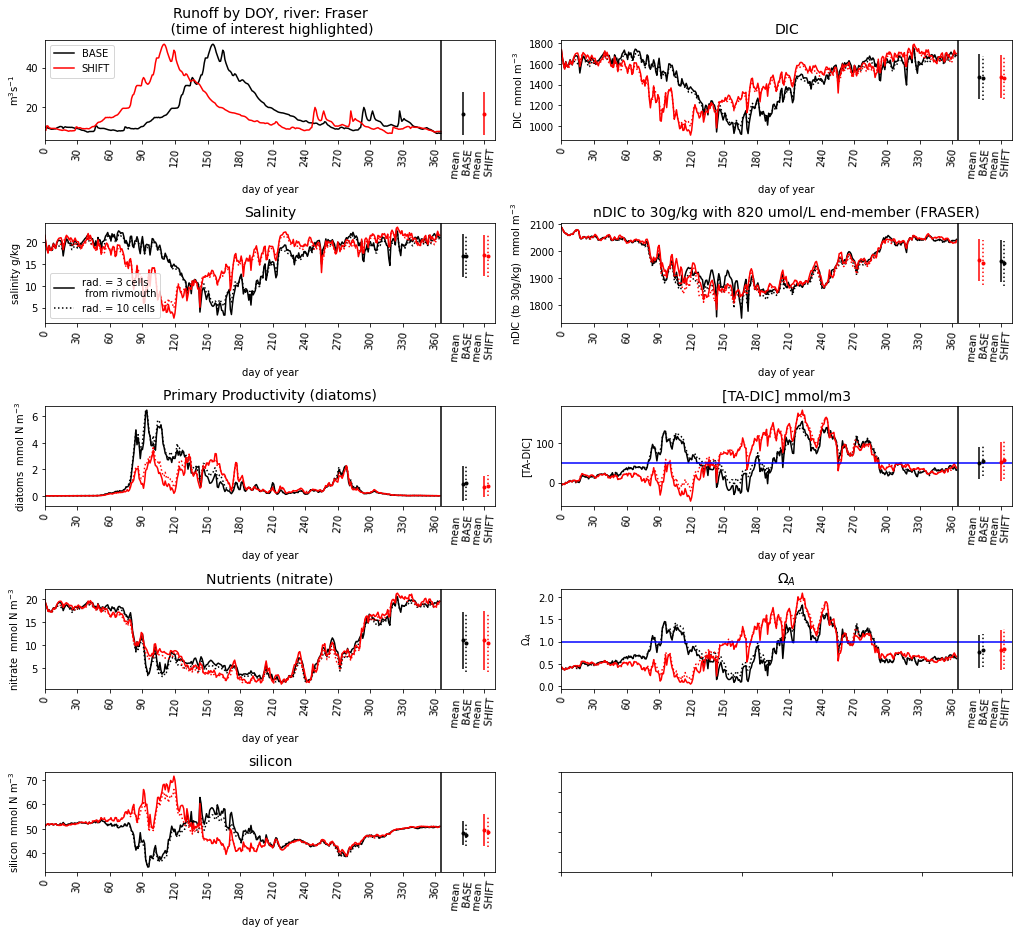

In [24]:
whsed = 'fraser'
rivnam = 'Fraser'
rivstr = './pkls/Fraser_20170101_20171231.pkl'
rivstr_SHIFT = './pkls/Fraser_SHIFT_20170101_20171231.pkl'
sd = 0
ed = 364
make_diag_plot_dictv(whsed, rivnam, rivstr, rivstr_SHIFT, sd, ed)




# bute

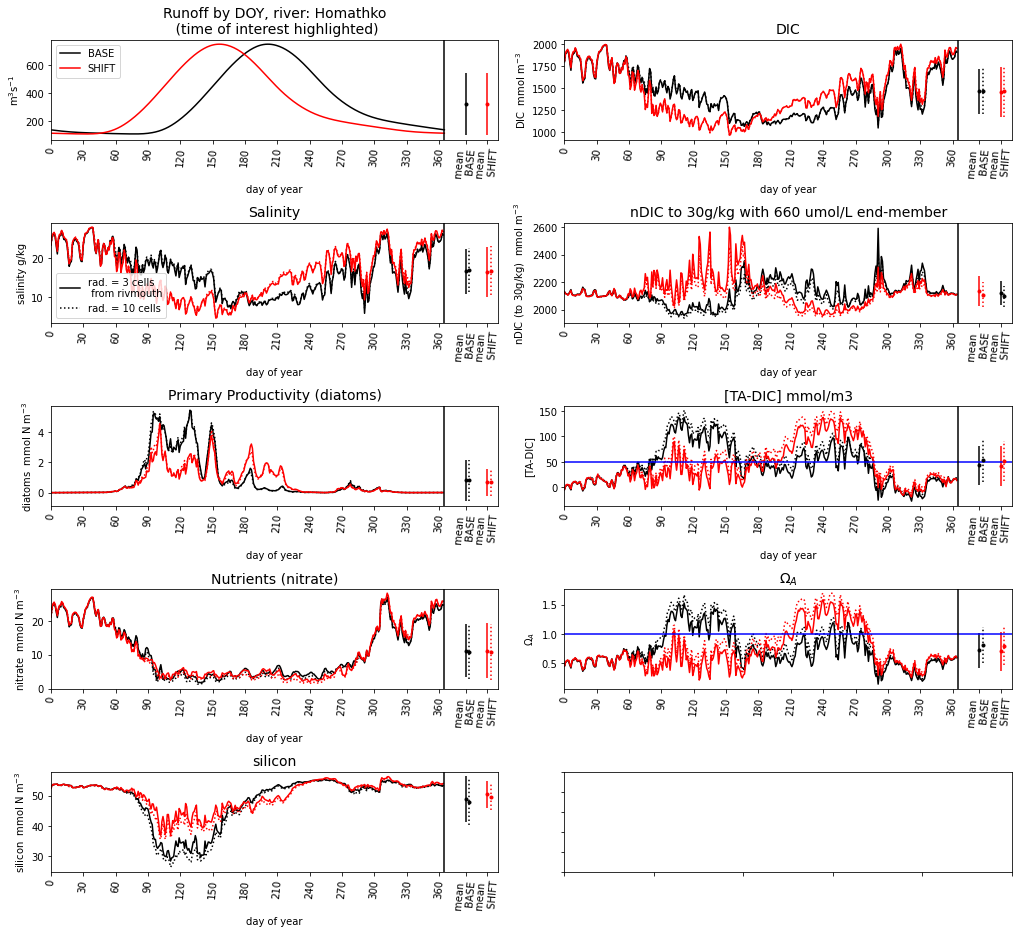

In [25]:
whsed = 'bute'
rivnam = 'Homathko'
rivstr = './pkls/Homathko_20170101_20171231.pkl'
rivstr_SHIFT = './pkls/Homathko_SHIFT_20170101_20171231.pkl'
sd = 0
ed = 364
make_diag_plot_dictv(whsed, rivnam, rivstr, rivstr_SHIFT, sd, ed)



# toba

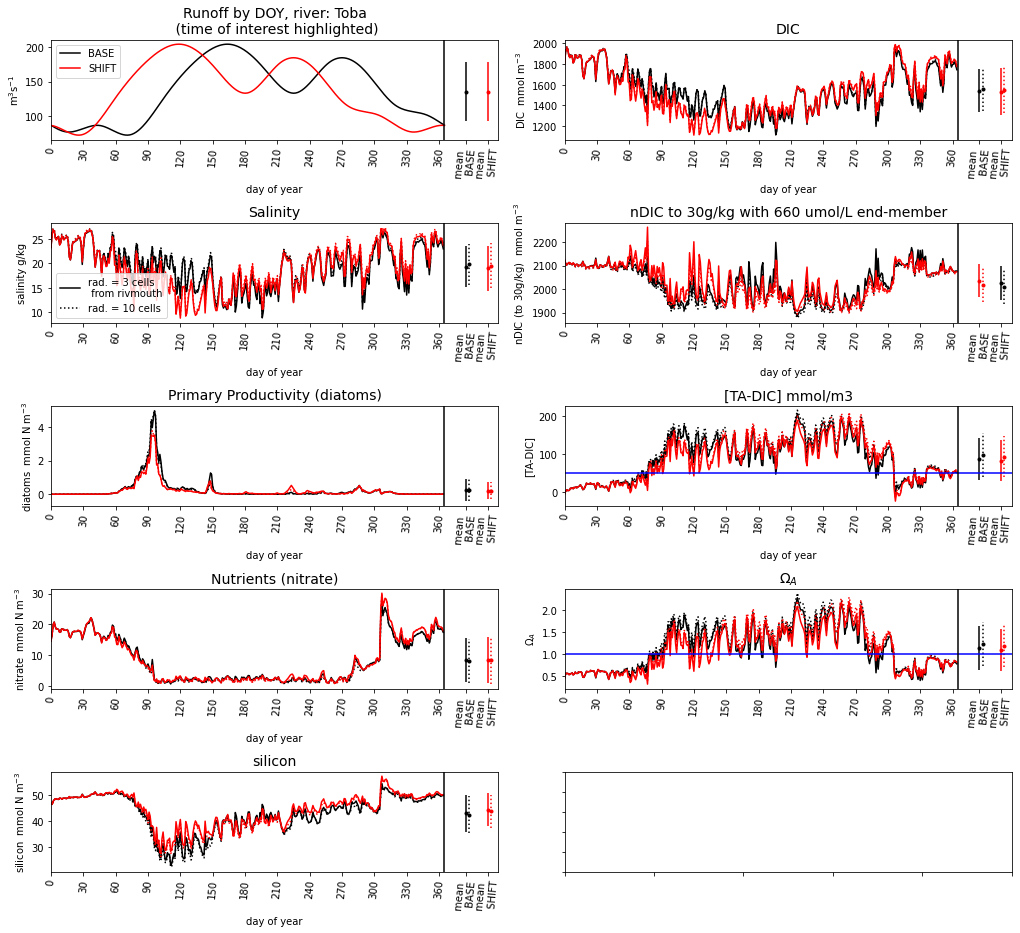

In [26]:
whsed = 'toba'
rivnam = 'Toba'
rivstr = './pkls/Toba_20170101_20171231.pkl'
rivstr_SHIFT = './pkls/Toba_SHIFT_20170101_20171231.pkl'
sd = 0
ed = 364
make_diag_plot_dictv(whsed, rivnam, rivstr, rivstr_SHIFT, sd, ed)



# Unchanged hydrographs - Powell

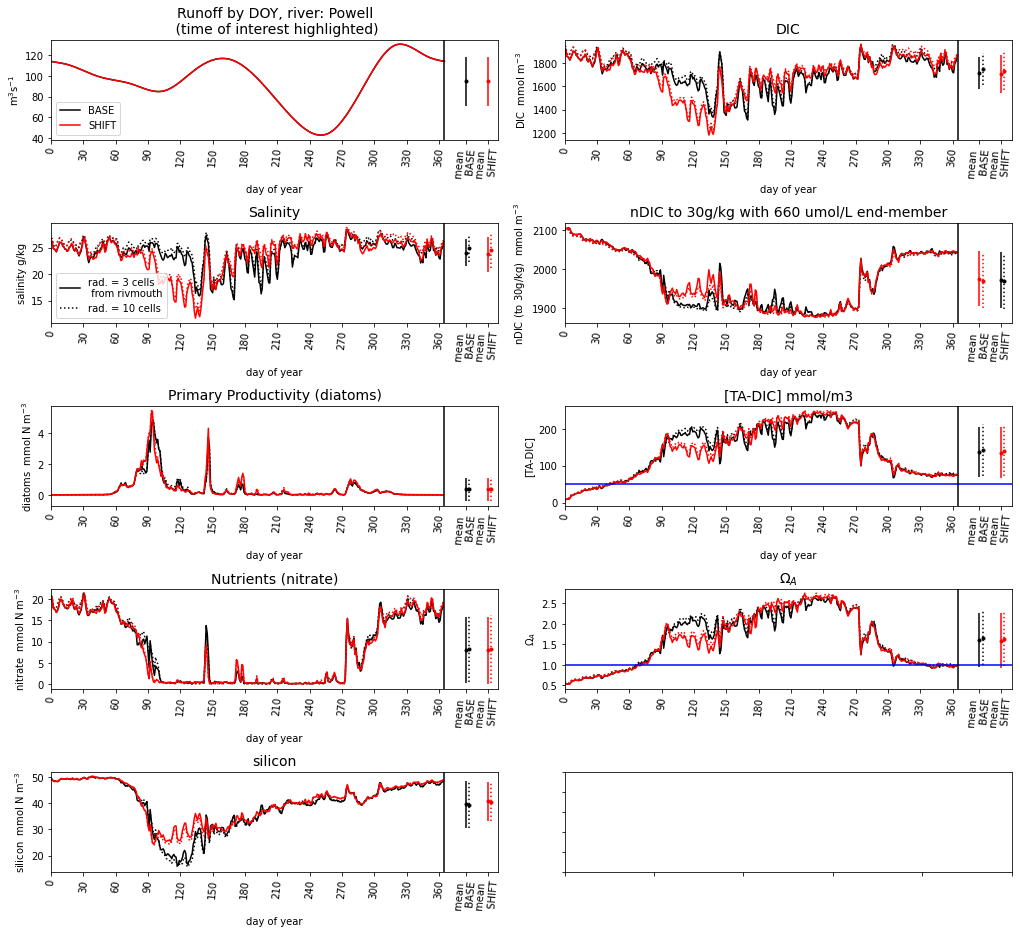

In [27]:
whsed = 'jervis'
rivnam = 'Powell'
rivstr = './pkls/Powell_20170101_20171231.pkl'
rivstr_SHIFT = './pkls/Powell_SHIFT_20170101_20171231.pkl'
sd = 0
ed = 364
make_diag_plot_dictv(whsed, rivnam, rivstr, rivstr_SHIFT, sd, ed)


# Unchanged hydrographs - Puntledge

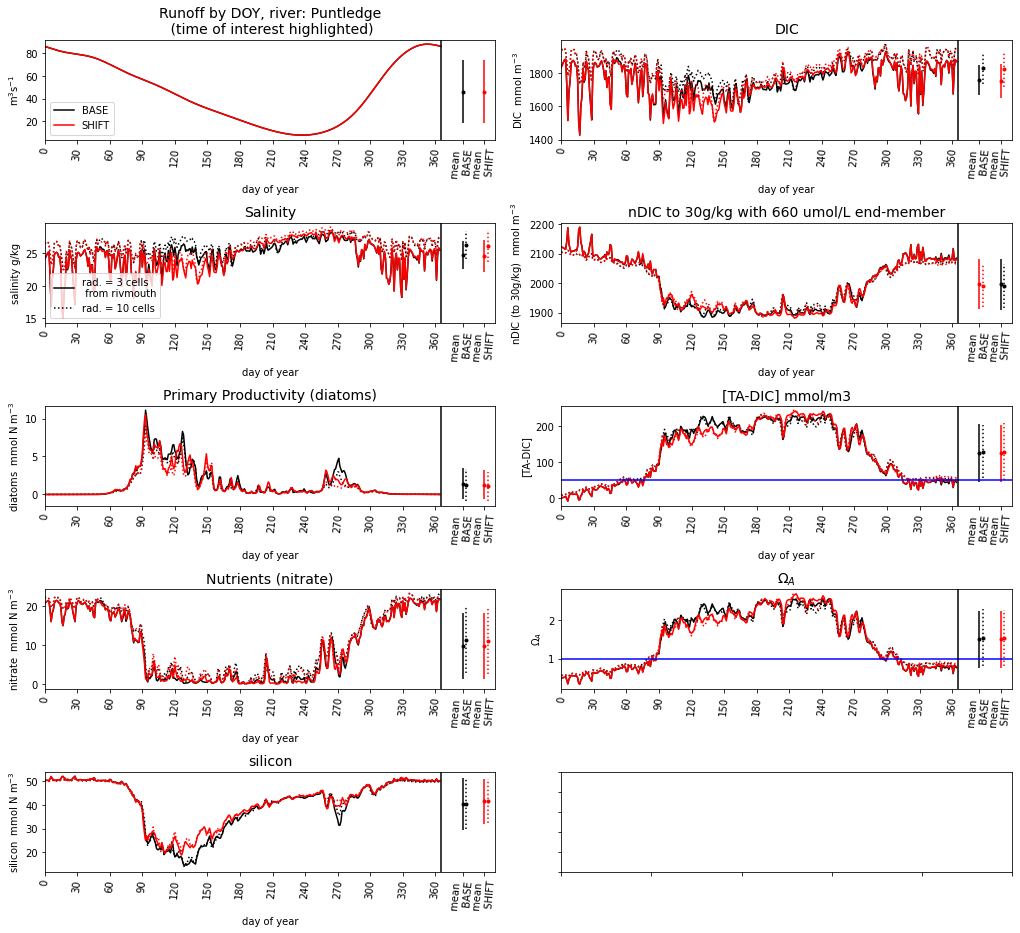

In [28]:

whsed = 'evi_s'
rivnam = 'Puntledge'
rivstr = './pkls/Puntledge_20170101_20171231.pkl'
rivstr_SHIFT = './pkls/Puntledge_SHIFT_20170101_20171231.pkl'
sd = 0
ed = 364
make_diag_plot_dictv(whsed, rivnam, rivstr, rivstr_SHIFT, sd, ed)